In [25]:
import sys
sys.path.append('../data/')
sys.path.append('../src/')
sys.path.append('../libs/')

import numpy as np
import tensorflow as tf
import scipy.linalg as la
import matplotlib.pyplot as plt

import MNIST_DATA

<h1>Handwritten Digits</h1>

In [55]:
mnist = MNIST_DATA.MNIST_DATA()

<h2>Graph Convolutional Network</h2>

It doesn't make sense to slide a filter over a graph, so graph convolutional networks use a definition of convolution by analogy. In a Euclidean space, the convolution of two signals in the frequency domain is the product of the signals in the frequency domain. Similarly, for two signals $f$ and $g$ defined in vertex space, the convolution is
\begin{equation}
    f \star g = \sum^n_{k = 1} \left( \hat f_k \hat g_k \right) u_k
\end{equation}
where $\hat f_k, \hat g_k$ are coefficients of the $k$th frequency component, and $u_k$ is the basis vector corresponding to the $k$th frequency component.

Frequency components are obtained by the Graph Fourier Transform (GFT). If $G$ is a graph with Laplacian $L$, then the Fourier basis for a signal $x$ defined over the vertices of $G$ are the columns of the orthonormal matrix $U$, defined by the spectral decomposition $L = U^T \Lambda U$. Hence, if $x$ is a signal in the vertex domain, the corresponding frequency domain signal is $\hat x = U^T x$.

<h3>Lattice Frequency Domain</h3>

All of the handwritten digits are defined over the same graph, a 28 $\times$ 28 lattice. We can obtain the Laplacian as follows:

In [173]:
def get_lattice_laplacian(n):
    d, I = la.toeplitz(np.eye(1, n, 1)), np.eye(n)
    A = np.kron(d, I) + np.kron(I, d)
    degrees = np.sum(A, axis = 0)
    N = np.diag(np.power(degrees, -0.5))
    L = np.identity(n ** 2) - np.linalg.multi_dot([N, A, N])
    return L

Then perform the spectral decomposition to obtain frequencies and frequency components:

In [171]:
def gft(L):
    lamb, U = np.linalg.eig(L)
    return lamb, U

Let's see what some of the frequency components look like for the lattice graph.

In [174]:
L = get_lattice_laplacian(28)
lamb, U = gft(L)

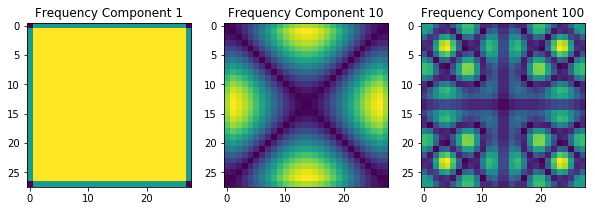

In [199]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(np.reshape(U[:, 0], (28, 28))))
plt.title('Frequency Component 1')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(np.reshape(U[:, 9], (28, 28))))
plt.title('Frequency Component 10')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(np.reshape(U[:, 99], (28, 28))))
plt.title('Frequency Component 100')
plt.show()

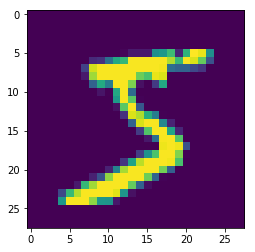

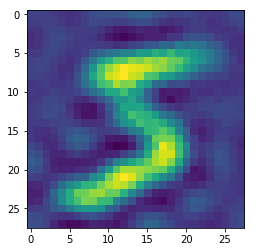

In [208]:
img = np.array(mnist.train_data[0], dtype = 'float64')
img = img / 255

img_hat = np.dot(np.transpose(U), img)

img_hat_mod = np.copy(img_hat)
img_hat_mod[200:] = 0
img_mod = np.dot(U, img_hat_mod)

plt.imshow(np.reshape(img, (28, 28)))
plt.show()

plt.imshow(np.reshape(img_mod, (28, 28)))
plt.show()

Any of the handwritten digits can be written as a linear combination of the 784 frequency components.

<h3>Spectral Filters</h3>

The point of a convolutional neural network is to learn an optimal filter with which the signal is convolved. For graph convolutional networks, it is common to use a filter which is polynomial in the frequency domain.

In [184]:
L = get_lattice_laplacian(28)
[lamb, U] = gft(L)

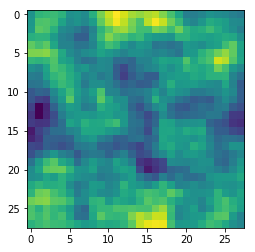

In [197]:
size = 28 ** 2

def filter(img, W):
    
    # Calculate Fourier transform of image 
    img_hat = np.dot(np.transpose(U), img)
    
    # Get convolution in frequency domain
    h_hat = np.empty(size)
    for k in range(size):
        g_hat = np.polynomial.chebyshev.chebval(lamb[k] - 1, W[k, :])
        h_hat[k] = img_hat[k] * g_hat
        
    # Return convolution in vertex domain
    return np.dot(U, h_hat)
        
W = np.random.normal(0, 1e-2, (size, size))
H = filter(img, W)
H_img = np.reshape(H, (28, 28))
plt.imshow(H_img)
plt.show()

<h2>Neural Network</h2>

In [211]:
N_FILTERS = 4

img = tf.placeholder(tf.float64, shape = size)
img_hat = tf.matmul(U, tf.expand_dims(img, 1), transpose_a = True)

conv_filters = []
conv_weights = []
filter_hat = []

for n in range(N_FILTERS):
    
    # Initialize random weights for filter n
    w_init = np.random.rand(size, size)
    conv_weights.append(tf.Variable(w_init))
    
    # Write filter n output
    np.polynomial.chebyshev

In [220]:
C = np.polynomial.chebyshev.cheb2poly(np.array([1, 1, 1, 1, 1, 1]))
print(C)

[  1.   3.  -6. -16.   8.  16.]
